In [9]:
def my_imfilter(image, kernel):
    """
    Your function should meet the requirements laid out on the project webpage.
    Apply a filter (using kernel) to an image. Return the filtered image. To
    achieve acceptable runtimes, you MUST use numpy multiplication and summation
    when applying the kernel.
    Inputs
    - image: numpy nd-array of dim (m,n) or (m, n, c)
    - kernel: numpy nd-array of dim (k, l)
    Returns
    - filtered_image: numpy nd-array of dim of equal 2D size (m,n) or 3D size (m, n, c)
    Errors if:
    - filter/kernel has any even dimension -> raise an Exception with a suitable error message.
    """

    ##################
    # Your code here #
    ##################

    rotate_kernel = np.flip(kernel)

    kernel_row, kernel_col = rotate_kernel.shape

    if (kernel_row % 2 == 0) or (kernel_col % 2 == 0):
        raise Exception('Kernel is not of odd dimensions')

    color_channel = []
    num_channel = 1
    if len(image.shape) == 2:
        # grayscale image
        color_channel.append(image)
    elif len(image.shape) == 3:
        # RGB image
        num_channel = image.shape[2]
        for i in range(image.shape[2]):
            color_channel.append(image[:, :, i])
    else:
        return

    padding_row = kernel_row // 2
    padding_col = kernel_col // 2

    for i in range(num_channel):
        channel = color_channel[i]
        result = np.zeros(channel.shape, dtype=np.float32)
        channel_padded = np.pad(
            channel, [(padding_row, padding_row), (padding_col, padding_col)], mode='reflect')
        for col in range(channel.shape[1]):
            for row in range(channel.shape[0]):
                result[row, col] = (
                        rotate_kernel * channel_padded[row: row + kernel_row, col: col + kernel_col]).sum()
        color_channel[i] = result

    if num_channel == 1:
        filtered_image = color_channel[0]
    else:
        filtered_image = np.stack(color_channel, axis=2)
    return filtered_image

/var/folders/2g/pjprd15j09dgkgb74j6bf_5r0000gn/T/ipykernel_78250/2112562414.py:25: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  test_image = rescale(test_image, 0.7, mode='reflect', multichannel=True)


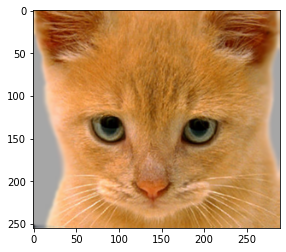

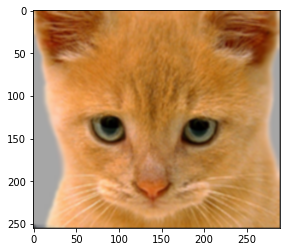

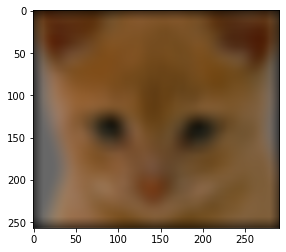

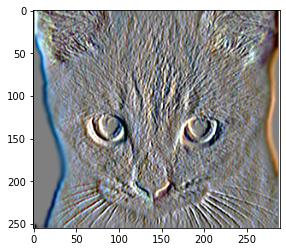

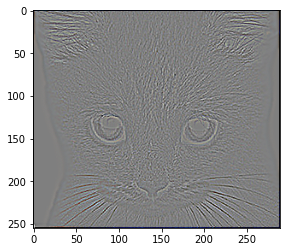

ValueError: operands could not be broadcast together with shapes (253,287,3) (255,289,3) 

In [11]:
# Spring 2022: Image Processing and Computer Vision
# Beihang Univeristy
# Homework set 1
# Lu Sheng (lsheng@buaa.edu.cn)
#
# Tests on my_imfilter function
#
# Based on previous and current work
# by James Hays for CSCI 1430 @ Brown and
# CS 4495/6476 @ Georgia Tech
import os
from skimage.transform import rescale
import numpy as np
from numpy import pi, exp, sqrt
import matplotlib.pyplot as plt
from helpers import load_image, save_image

from student import my_imfilter

resultsDir = '..' + os.sep + 'results'
if not os.path.exists(resultsDir):
    os.mkdir(resultsDir)

test_image = load_image('../data/3-cat.bmp')
test_image = rescale(test_image, 0.7, mode='reflect', multichannel=True)

'''
Identity filter
This filter should do nothing regardless of the padding method you use.
'''
identity_filter = np.asarray(
    [[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)
identity_image = my_imfilter(test_image, identity_filter)
plt.imshow(identity_image)
plt.show()
done = save_image('../results/identity_image.jpg', identity_image)


'''
Small blur with a box filter
This filter should remove some high frequencies.
'''
blur_filter = np.ones((3, 3), dtype=np.float32)
# making the filter sum to 1
blur_filter /= np.sum(blur_filter, dtype=np.float32)
blur_image = my_imfilter(test_image, blur_filter)
plt.imshow(blur_image)
plt.show()
done = save_image(resultsDir + os.sep + 'blur_image.jpg', blur_image)


'''
Large blur
This blur would be slow to do directly, so we instead use the fact that 
Gaussian blurs are separable and blur sequentially in each direction.
'''
# generate a 1x(2k+1) gaussian kernel with mean=0 and sigma = s, see 
# https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python
s, k = 10, 12
large_1d_blur_filter = np.asarray(
    [exp(-z*z/(2*s*s))/sqrt(2*pi*s*s) for z in range(-k, k+1)], dtype=np.float32)
large_1d_blur_filter = large_1d_blur_filter.reshape(-1, 1)
large_blur_image = my_imfilter(test_image, large_1d_blur_filter)
# notice the T operator which transposes the filter
large_blur_image = my_imfilter(large_blur_image, large_1d_blur_filter.T)
plt.imshow(large_blur_image)
plt.show()
done = save_image(resultsDir + os.sep +
                  'large_blur_image.jpg', large_blur_image)

# Slow (naive) version of large blur
# import time
# large_blur_filter = np.dot(large_1d_blur_filter, large_1d_blur_filter.T)
# t = time.time()
# large_blur_image = my_imfilter(test_image, large_blur_filter);
# t = time.time() - t
# print('{:f} seconds'.format(t))
##

'''
Oriented filter (Sobel operator)
'''
sobel_filter = np.asarray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
                          dtype=np.float32)  # should respond to horizontal gradients
sobel_image = my_imfilter(test_image, sobel_filter)

# 0.5 added because the output image is centered around zero otherwise and mostly black
sobel_image = np.clip(sobel_image+0.5, 0.0, 1.0)
plt.imshow(sobel_image)
plt.show()
done = save_image(resultsDir + os.sep + 'sobel_image.jpg', sobel_image)


'''
High pass filter (discrete Laplacian)
'''
laplacian_filter = np.asarray(
    [[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
laplacian_image = my_imfilter(test_image, laplacian_filter)

# added because the output image is centered around zero otherwise and mostly black
laplacian_image = np.clip(laplacian_image+0.5, 0.0, 1.0)
plt.figure()
plt.imshow(laplacian_image)
plt.show()
done = save_image(resultsDir + os.sep + 'laplacian_image.jpg', laplacian_image)

# High pass "filter" alternative
high_pass_image = test_image - blur_image
high_pass_image = np.clip(high_pass_image+0.5, 0.0, 1.0)
plt.figure()
plt.imshow(high_pass_image)
plt.show()
done = save_image(resultsDir + os.sep + 'high_pass_image.jpg', high_pass_image)
